In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
from torchinfo import summary

import os
import glob
import time
import datetime as dt
from netCDF4 import Dataset as nc_Dataset
from netCDF4 import date2num, num2date
import pandas as pd
import numpy as np
import math
import xarray as xr
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.markers import MarkerStyle
import cartopy.crs as ccrs
import cartopy.feature as cfeature


In [2]:
MIN_IDX_LON = 250
MIN_IDX_LAT = 400
IMG_SIZE_LON = 800
IMG_SIZE_LAT = 800

In [3]:
PATH_HRRR_ORIGINAL = f"/data1/projects/RTMA/alex.schein/Regridded_HRRR/t2m"

In [4]:
var = xr.open_dataarray(f"{PATH_HRRR_ORIGINAL}/20201231/hrrr_regridded_20201231_t23z_f01.grib2", engine="cfgrib", decode_timedelta=True)

In [6]:
var_sp_rest = var.isel(y=slice(MIN_IDX_LAT, MIN_IDX_LAT+IMG_SIZE_LAT),
                        x=slice(MIN_IDX_LON, MIN_IDX_LON+IMG_SIZE_LON))

In [8]:
var_ijsmallgrib = xr.open_dataarray(f"/scratch/RTMA/alex.schein/test_ijsmallgrib.grib2", engine="cfgrib", decode_timedelta=True)

In [15]:
var_sp_rest

<xarray.DataArray 't2m' (y: 800, x: 800)> Size: 3MB
[640000 values with dtype=float32]
Coordinates:
    time               datetime64[ns] 8B ...
    step               timedelta64[ns] 8B ...
    heightAboveGround  float64 8B ...
    latitude           (y, x) float64 5MB 29.37 29.37 29.37 ... 49.08 49.08
    longitude          (y, x) float64 5MB 237.7 237.7 237.7 ... 257.4 257.5
    valid_time         datetime64[ns] 8B ...
Dimensions without coordinates: y, x
Attributes: (12/34)
    GRIB_paramId:                             167
    GRIB_dataType:                            fc
    GRIB_numberOfPoints:                      3744965
    GRIB_typeOfLevel:                         heightAboveGround
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_name:                                2 metre temperature
    GRIB_shortName:                           2t
    GRIB_units:                               K
    long_name:                                2 metre temperature
    units:                                    K
    standard_name:                            air_temperature

In [14]:
var_ijsmallgrib

<xarray.DataArray 'd2m' (y: 800, x: 800)> Size: 3MB
[640000 values with dtype=float32]
Coordinates:
    time               datetime64[ns] 8B ...
    step               timedelta64[ns] 8B ...
    heightAboveGround  float64 8B ...
    latitude           (y, x) float64 5MB 29.34 29.34 29.35 ... 49.06 49.06
    longitude          (y, x) float64 5MB 237.7 237.7 237.7 ... 257.4 257.4
    valid_time         datetime64[ns] 8B ...
Dimensions without coordinates: y, x
Attributes: (12/34)
    GRIB_paramId:                             168
    GRIB_dataType:                            fc
    GRIB_numberOfPoints:                      640000
    GRIB_typeOfLevel:                         heightAboveGround
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_name:                                2 metre dewpoint temperature
    GRIB_shortName:                           2d
    GRIB_units:                               K
    long_name:                                2 metre dewpoint temperature
    units:                                    K
    standard_name:                            unknown

In [10]:
var_ijsmallgrib.longitude.data

array([[237.673855  , 237.69945574, 237.72505844, ..., 258.55741764,
        258.58402631, 258.61063548],
       [237.6686231 , 237.69422847, 237.71983581, ..., 258.55615198,
        258.58276586, 258.60938024],
       [237.66338923, 237.68899923, 237.71461121, ..., 258.55488582,
        258.58150492, 258.60812451],
       ...,
       [232.76839534, 232.79826976, 232.82814737, ..., 257.36190369,
        257.39343084, 257.4249588 ],
       [232.76115478, 232.7910354 , 232.82091921, ..., 257.36012521,
        257.39165966, 257.42319494],
       [232.75391104, 232.78379786, 232.81368787, ..., 257.35834589,
        257.38988766, 257.42143025]])

In [16]:
var_sp_rest.longitude.data - var_ijsmallgrib.longitude.data

array([[0.02037428, 0.02038089, 0.0203875 , ..., 0.02534908, 0.02535479,
        0.02536049],
       [0.02037694, 0.02038355, 0.02039016, ..., 0.0253538 , 0.02535951,
        0.02536521],
       [0.0203796 , 0.02038621, 0.02039283, ..., 0.02535852, 0.02536423,
        0.02536994],
       ...,
       [0.02264101, 0.0226504 , 0.02265979, ..., 0.02975698, 0.02976512,
        0.02977325],
       [0.02264402, 0.02265341, 0.02266281, ..., 0.02976347, 0.02977161,
        0.02977974],
       [0.02264703, 0.02265643, 0.02266582, ..., 0.02976996, 0.0297781 ,
        0.02978624]])

In [17]:
var_sp_rest.latitude.data - var_ijsmallgrib.latitude.data

array([[0.02687471, 0.02687119, 0.02686766, ..., 0.02373936, 0.02373507,
        0.02373078],
       [0.02687458, 0.02687106, 0.02686753, ..., 0.02373844, 0.02373415,
        0.02372986],
       [0.02687445, 0.02687092, 0.0268674 , ..., 0.02373752, 0.02373323,
        0.02372893],
       ...,
       [0.02551461, 0.02551021, 0.0255058 , ..., 0.02184009, 0.02183533,
        0.02183056],
       [0.0255114 , 0.02550699, 0.02550258, ..., 0.02183635, 0.02183158,
        0.02182682],
       [0.02550819, 0.02550378, 0.02549937, ..., 0.0218326 , 0.02182784,
        0.02182308]])

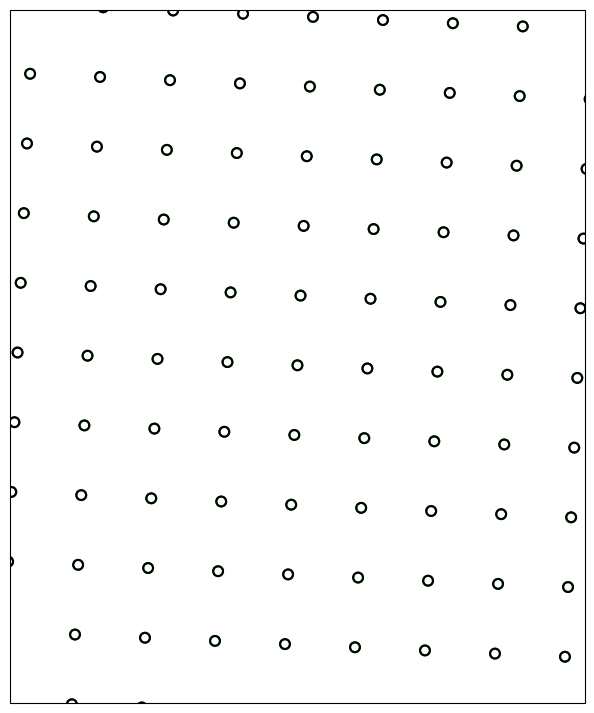

In [12]:
projection = ccrs.LambertConformal(central_longitude = 265-360,
                                    central_latitude = 38.5,
                                    standard_parallels = (38.5,38.5),
                                    cutoff = 0)

fig = plt.figure(figsize=(9,9))
ax1 = fig.add_subplot(1,1,1, projection=projection)

ax1.set_extent([252-360, 252.2-360, 39, 39.2])
ax1.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=1)
ax1.add_feature(cfeature.STATES.with_scale('50m'))
mks = MarkerStyle('o', fillstyle="none")

# ax1.scatter(urma_orig_sp_rest.longitude.data, urma_orig_sp_rest.latitude.data, transform=ccrs.PlateCarree(), s=50, c='r', marker=mks, label='URMA original')
ax1.scatter(var_sp_rest.longitude.data, var_sp_rest.latitude.data, transform=ccrs.PlateCarree(), s=50, c='g', marker=mks, label='URMA reset radius')
ax1.scatter(var_ijsmallgrib.longitude.data, var_ijsmallgrib.latitude.data, transform=ccrs.PlateCarree(), s=50, c='k', marker =mks, label='HRRR 6370000 new spacing')
# ax1.scatter(hrrr_6371950_sp_rest.longitude.data, hrrr_6371950_sp_rest.latitude.data, transform=ccrs.PlateCarree(), s=50, c='b', marker =mks, label='HRRR R=6371950')


# plt.title("Grid alignment, URMA vs Regridded HRRR")
# plt.legend(loc='lower left')
# plt.savefig("grid_alignment.png", dpi=200, bbox_inches='tight')

In [ ]:
# projection = ccrs.LambertConformal(central_longitude = 265-360,
#                                     central_latitude = 38.5,
#                                     standard_parallels = (38.5,38.5),
#                                     cutoff = 0)

# fig = plt.figure(figsize=(12,12))
# ax1 = fig.add_subplot(1,1,1, projection=projection)

# #ax1.set_extent([235-360, 265-360, 30, 45])
# ax1.set_extent([235-360, 260-360, 30, 48])
# ax1.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=1)
# ax1.add_feature(cfeature.STATES.with_scale('50m'))
# # mks = MarkerStyle('o', fillstyle="none")

# THINNING = 20

# # ax1.contourf(var.longitude.data[::THINNING,::THINNING], var.latitude.data[::THINNING,::THINNING], var.data[::THINNING,::THINNING], levels=50, transform=ccrs.PlateCarree(), cmap="coolwarm")
# ax1.contourf(var.longitude.data[MIN_IDX_LAT:MIN_IDX_LAT+IMG_SIZE_LAT, MIN_IDX_LON:MIN_IDX_LON+IMG_SIZE_LON], 
#              var.latitude.data[MIN_IDX_LAT:MIN_IDX_LAT+IMG_SIZE_LAT, MIN_IDX_LON:MIN_IDX_LON+IMG_SIZE_LON], 
#              var.data[MIN_IDX_LAT:MIN_IDX_LAT+IMG_SIZE_LAT, MIN_IDX_LON:MIN_IDX_LON+IMG_SIZE_LON], 
#              levels=40, transform=ccrs.PlateCarree(), cmap="coolwarm")

# # plt.savefig(f"/scratch/RTMA/alex.schein/new_domain_20250728.png", bbox_inches='tight', dpi=200)

In [ ]:
np.where(np.isnan(var.data[MIN_IDX_LAT:MIN_IDX_LAT+IMG_SIZE_LAT, MIN_IDX_LON:MIN_IDX_LON+IMG_SIZE_LON]))